In [7]:
from spectrometerClass import *

from win32com.client import Dispatch
import time
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.io import fits as pyfits
from astropy import units as u

import os

In [8]:
try:
    spec = Spectrometer()
except:
    raise
else:
    print("Connected.")

Connected.


In [44]:
532-509

23

In [45]:
546-23

523

In [14]:
# target = 696+23+30
target = 656
spec.giveCommand(f'gowave {target-23}')

In [85]:
spec.giveCommand('grat 2')

In [147]:
spec.giveCommand('step 600')

In [3]:
wave = spec.giveCommand('grat?')

In [4]:
print(wave)

2,1200,500


In [17]:
print(spec.giveCommand('grat2factor?'))
# Also get grat2offset and grat2zero
print(spec.giveCommand('grat2offset?'))
print(spec.giveCommand('grat2zero?'))


1.000400
0.080920
2.1816616


In [132]:
spec.getWavelength()

-73.012

In [40]:
# Connect to ZWO camera
camera = Dispatch('ASCOM.ASICamera2.Camera')
# Open setup dialog
camera.SetupDialog()

# Connect to camera
camera.Connected = True

# Camera name
print(camera.Name)


ZWO ASI1600MM Pro


In [41]:

# Set camera temperature
camera.SetCCDTemperature = -10

# Turn on cooler
camera.CoolerOn = True

In [42]:
# Get camera temperature
print(camera.CCDTemperature)

-8.0


In [10]:
def capture_image(camera, exposure):
    '''
    Capture image using camera and return as numpy array
    
    Parameters
    ----------
    camera : Dispatch
        Camera object
    exposure : float
        Exposure time in seconds

    Returns
    -------
    image : numpy array
        Image data in 16 bit unsigned integer format
    '''

    # Start exposure
    camera.StartExposure(exposure, True)

    # Wait for exposure to complete
    while camera.ImageReady == False:
        time.sleep(0.05)
    
    # Get image data
    image = camera.ImageArray

    # Change to 16 bit unsigned integer numpy array
    image = np.array(image, dtype=np.uint16)

    return image
    

In [16]:
img = take_spectrum(1, 656)

Grating: 3, 1200 lpm, 750 nm blaze
Wavelength: 655.994 nm


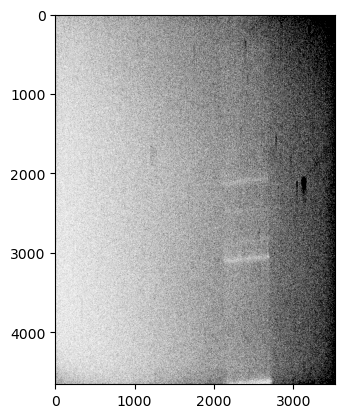

In [17]:
# Plot image using ZScaleInterval
norm = ImageNormalize(img, interval=ZScaleInterval())
plt.imshow(img, norm=norm, cmap='gray')
plt.show()

Above is a spectrum of the lights in 666B, showing that we need a way to get the input fiber vertically aligned (or otherwise be able to account for the angle shown in the spectral lines).

In [29]:
def save_spectrum(image, exposure, wavelength, wave, grating_params):
    ''' Save spectrum to FITS file along with header information '''
    # Change image data type to 16-bit unsigned integer (required by FITS standard)
    # and convert to numpy array
    image = np.array(image, dtype=np.uint16)
    # Save image to file
    image_file_path_tmp = os.path.join(os.getcwd(), 'testfits.tmp')
    image_file_path_final = os.path.join(os.getcwd(), 'testfits.fits')
    pyfits.writeto(image_file_path_tmp, image, overwrite=True)

    [grating, gratline, gratblaz] = grating_params

    # Set grating, gratline, gratblaz to integers
    grating = int(grating); gratline = int(gratline); gratblaz = int(gratblaz)

    # Add FITS header information
    hdulist = pyfits.open(image_file_path_tmp, mode="update")
    header = hdulist[0].header
    header.set("SPECID", 'MS260i', "Spectrometer ID")
    header.set("SPECPOS", wave, "Spectrometer position (nm)")
    header.set("NOMWAVE", wavelength, "Nominal wavelength (nm)")
    header.set("EXPTIME", exposure, "Exposure time (s)")
    header.set("GRATING", grating, "Grating number")
    header.set("GRATLINE", gratline, "Grating lines/mm")
    header.set("GRATBLAZ", gratblaz, "Grating blaze wavelength (nm)")

    hdulist.flush()
    hdulist.close()

    # Move modified FITS file into final location, replacing any file
    # that may already be there. By writing to another file and then
    # renaming it at the last second, we make sure that other processed
    # (like the file transfer daemon) don't see incomplete, partially-written
    # files
    #remove_file_if_needed(image_file_path_final)
    # remove any existing file
    if os.path.exists(image_file_path_final):
        os.remove(image_file_path_final)
    os.rename(image_file_path_tmp, image_file_path_final)
    #logging.info("Final file saved to %s", image_file_path_final)

In [38]:
def take_spectrum(exposure, wavelength):
    ''' Set spectrometer to wavelength, capture image of exposure time,
    using camera, return image as numpy array '''
    spec.setWavelength(wavelength)
    grating = spec.getGrating()
    wave = spec.getWavelength()
    print('Wavelength: ' + str(wave) + ' nm')

    # Take image
    image = capture_image(camera, exposure)
    # Rotate image 90 degrees to match expected orientation
    image = np.rot90(image, 3)
    save_spectrum(image, exposure, wavelength, wave, grating)

    return image

In [45]:
take_spectrum(2, 600)

Wavelength: 599.989 nm


array([[1568, 1584, 1696, ..., 1760, 1840, 1776],
       [1760, 1760, 1856, ..., 1840, 1840, 1776],
       [1504, 1680, 1520, ..., 1584, 1936, 1904],
       ...,
       [1664, 1456, 1552, ..., 1328, 1440, 1328],
       [1536, 1600, 1600, ..., 1584, 1440, 1536],
       [1536, 1600, 1760, ..., 1424, 1504, 1296]], dtype=uint16)

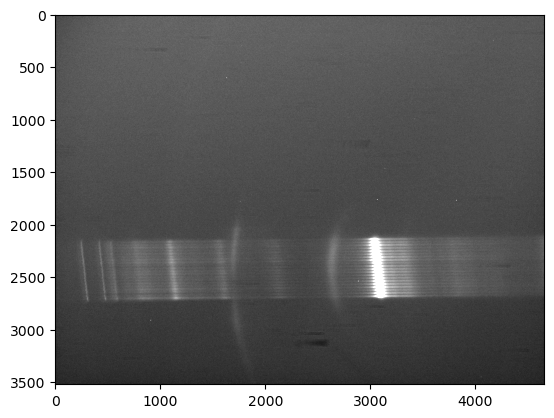

In [46]:
# Display image using ZScaleInterval

# Load image from testfits.fits
image = pyfits.getdata('testfits.fits')


# Plot image using ZScaleInterval
norm = ImageNormalize(image, interval=ZScaleInterval())
plt.imshow(image, norm=norm, cmap='gray')
plt.show()

In [47]:
# Get image statistics
print('Mean: ' + str(np.mean(image)))

Mean: 1745.329376562012


In [48]:
# Get header information
header = pyfits.getheader('testfits.fits')
# Print header, line by line, with comments
for key in header:
    print(key + ': ' + str(header[key]) + ' / ' + str(header.comments[key]))

SIMPLE: True / conforms to FITS standard
BITPIX: 16 / array data type
NAXIS: 2 / number of array dimensions
NAXIS1: 4656 / 
NAXIS2: 3520 / 
EXTEND: True / 
BSCALE: 1 / 
BZERO: 32768 / 
SPECID: MS260i / Spectrometer ID
SPECPOS: 599.989 / Spectrometer position (nm)
NOMWAVE: 600 / Nominal wavelength (nm)
EXPTIME: 2 / Exposure time (s)
GRATING: 3 / Grating number
GRATLINE: 1200 / Grating lines/mm
GRATBLAZ: 750 / Grating blaze wavelength (nm)


In [49]:
# Turn off cooler
camera.CoolerOn = False

In [53]:
# Camera temperature
print(camera.CCDTemperature)

-3.5


In [4]:
# Disconnect camera
camera.Connected = False

NameError: name 'camera' is not defined

In [5]:
# Disconnect spectrometer
spec.finish()